# Load the zip file and unzip and before check the GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Check the GPU is available or not
# IMPORT
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


# FETCH GPU NAME
device_name = tf.test.gpu_device_name()

# IF DEVICE IS NOT AVAILABLE FETCH ERROR
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# IMPORT DEPENDENCIES

import requests, zipfile, io
from glob import glob
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm, tqdm_notebook
import cv2
import pandas as pd
seed = 7
import pandas as pd
np.random.seed(seed)
import os

In [ ]:
zip_file_url = 'https://github.com/karoldvl/ESC-50/archive/master.zip' # link: ESC-50 Datset

In [ ]:
# CREATE FOLDER WITH NAME SOUND IF NOT EXIST
if not os.path.exists('sound'):
    os.makedirs('sound')

In [ ]:
# UNZIP THE DATA AND EXTRACT ALL FILES IN THE SOUND FOLDER
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('sound/')
z.close()

In [ ]:
# glob('sound/ESC-50-master/audio/*')

# Define a function to covert the image based on calculate log scaled mel-spectrograms and their corresponding deltas from a sound clip.

Regarding fixed size input, we will divide each sound clip into segments of 60x41 (60 rows and 41 columns). The mel-spec and their deltas will become two channels, which we will be fed into CNN

In [ ]:
# !pip install librosa
import librosa

In [ ]:
# for fn in tqdm_notebook(glob('sound/ESC-50-master/audio/1-100032-A-0.wav')):
fn = 'sound/ESC-50-master/audio/1-100032-A-0.wav'
sound_clip,s = librosa.load(fn) # 5sec
print(f'Sound Clip : {sound_clip} and Sample Rate : {s}')
sound_clip = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
print(f'Sound Clip : {sound_clip}')
label = fn.split("/")[-1].split("-")[-1].split(".")[0]
print(f'Label : {label}')

signal = sound_clip[0:10]
print(f'Signal : {signal}')
melspec = librosa.feature.mfcc(y = signal, sr = s)
print(f'"MFCC : {melspec}')
logspec = librosa.core.amplitude_to_db(melspec)
print(f'Print Logspecs ::::: {logspec}')
logspec = logspec.T.flatten()[:, np.newaxis].T
print(f'{logspec}')

Sound Clip : [0. 0. 0. ... 0. 0. 0.] and Sample Rate : 22050
Sound Clip : [0. 0. 0. ... 0. 0. 0.]
Label : 0
Signal : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
"MFCC : [[-1131.3708499]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]
 [    0.       ]]
Print Logspecs ::::: [[ 61.0720997]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]
 [-18.9279003]]
[[ 61.0720997 -18.9279003 -18.9279003 -18.9279003 -18.9279003 -18.9279003
  -18.9279003 -18.9279003 -18.9279003 -18.9279003 -18.9279003 -18.9279003
  -18.9279003 -18.9279003 -18.92

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for fn in tqdm(glob('sound/ESC-50-master/audio/*'), ascii=" .oO0"):
        sound_clip,s = librosa.load(fn) # 5sec
        sound_clip   = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
        label = fn.split("/")[-1].split("-")[-1].split(".")[0]
        # print(label)
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.mfcc(y=signal, sr=s, n_mfcc=40)
                # melspec = librosa.feature.poly_features(signal, sr = s)
                # melspec = librosa.feature.spectral_centroid(signal, sr = s)
                # melspec = librosa.feature.zero_crossing_rate(signal, sr = s)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [ ]:
features_mfcc,labels_mfcc = extract_features()

100%|##########| 2000/2000 [24:00<00:00,  1.34it/s]


ValueError: ignored

In [ ]:
# # save feature and label in npy format
# np.save(f"/content/drive/My Drive/Colab Notebooks/{features_mfcc}.npy", features_mfcc)
# np.save(f"/content/drive/My Drive/Colab Notebooks/{labels_mfcc}.npy", labels_mfcc)

In [ ]:
# load the npy file
features, labels = np.load(f'/content/drive/My Drive/Colab Notebooks/feature.npy'), np.load(f'/content/drive/My Drive/Colab Notebooks/labels.npy')

In [ ]:
labels

array([15, 15, 15, ...,  4,  4,  4])

In [ ]:
# label category names
df = pd.read_csv(glob('sound/ESC-50-master/meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head(5)

,target,category
0,0,dog
1,1,rooster
2,2,pig
3,3,cow
4,4,frog


In [ ]:
my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
# my_dict

In [ ]:
seed = 4
rng = np.random.RandomState(seed)
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
onehot_labels = to_categorical(labels,num_classes=50)

In [ ]:
# Create train test Dataset

rnd_indices = np.random.rand(len(labels)) < 0.70

X_train = features[rnd_indices]
y_train = onehot_labels[rnd_indices]
X_test  = features[~rnd_indices]
y_test  = onehot_labels[~rnd_indices]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27935, 60, 41, 2), (27935, 50), (12065, 60, 41, 2), (12065, 50))

# CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras.initializers import normal, VarianceScaling
from keras import initializers
from keras.layers import BatchNormalization,Activation
from keras import regularizers
### initializer of weights
# initializer = normal(mean=0, stddev=0.01, seed=13)
# initializer = VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)

from keras.applications import vgg16
from keras.models import Model
import keras

In [ ]:
# def basemodel():
#   model = Sequential()
#   model.add(Conv2D(filters=16, input_shape = (60,41,2),kernel_size=(7,7), strides=1, activation='relu'))
#   model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   model.add(BatchNormalization())

#   model.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu'))
#   model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   model.add(BatchNormalization())

#   model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'))
#   model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   model.add(BatchNormalization())

#   model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
#   model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   model.add(BatchNormalization())

#   # model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'))
#   # model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   # model.add(BatchNormalization())

#   model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu'))
#   model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
#   model.add(BatchNormalization())

#   model.add(Flatten())
#   model.add(Dense(1024))
#   model.add(Activation('relu'))
#   model.add(BatchNormalization())
#   model.add(Dropout(0.4))
#   model.add(Dense(50, activation='softmax'))
#   print(model.summary())
#   # Compile model
#   epochs, lrate = 25, 0.001
#   decay = lrate/epochs
    
# #     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#   adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
# #     rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=decay)
#   model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
#   return model

In [ ]:
def basemodel():
    # layer 1
    model = Sequential()
    # layer 1
    model.add(Conv2D(32, (7,7), strides=1, input_shape=(60,41,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # layer 2
    model.add(Conv2D(64, (3,3), activation = 'relu')))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128,(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # layer 3
    model.add(Conv2D(128, (3,3), strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256,(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer4
    # model.add(LSTM(128))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(50, activation = 'softmax' ))
    print(model.summary())
        
    # Compile model
    epochs, lrate = 25, 0.001
    decay = lrate/epochs
    
#     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
#     rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    return model

In [ ]:
if not os.path.exists('model'):
    os.makedirs('model')
    
filepath="model/weights_0.best_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# !cd sound
# !wget https://github.com/ashishpatel26/Audio-Classification-Data-Preparation/raw/master/Audio_Classification/weights_0.best.hdf5

In [ ]:
model = basemodel()
# model.load_weights('weights_0.best.hdf5')
# print(model.summary())












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 35, 32)        3168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 35, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 54, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 33, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 52, 33, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 52, 33, 32)        0   

# Training with Data Augmentation

One of the major reasons for overfitting is that we don’t have enough data to train our network. Apart from regularization, another very effective way to counter Overfitting is Data Augmentation. It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image. It can be a tedious task but fortunately, this can be done in Keras using the ImageDataGenerator instance.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
              horizontal_flip=False,  # randomly flip images
              vertical_flip=False  # randomly flip images
          )

In [ ]:
# init the batch size and epochs

'''
Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit. What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and 
save that and close program and repeat this work for your interested epoch For this [100,50] three times repeat 

'''
batch_size = 50
epochs = 200
print(epochs)

200


In [ ]:
# fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=1,callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (27935, 60, 41, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')




Epoch 1/200
559/559 [==============================] - 40s 71ms/step - loss: 3.0461 - acc: 0.1839 - val_loss: 2.8759 - val_acc: 0.2086

Epoch 00001: val_acc improved from -inf to 0.20862, saving model to model/weights_0.best_1.hdf5
Epoch 2/200
559/559 [==============================] - 35s 63ms/step - loss: 2.3912 - acc: 0.3144 - val_loss: 2.4585 - val_acc: 0.3123

Epoch 00002: val_acc improved from 0.20862 to 0.31231, saving model to model/weights_0.best_1.hdf5
Epoch 3/200
559/559 [==============================] - 35s 63ms/step - loss: 2.0665 - acc: 0.3997 - val_loss: 2.1901 - val_acc: 0.3700

Epoch 00003: val_acc improved from 0.31231 to 0.37000, saving model to model/weights_0.best_1.hdf5
Epoch 4/200
559/559 [==============================] - 35s 63ms/step - loss: 1.8403 - acc: 0.4602 - val_loss: 1.9987 - val_acc: 0.4083

Epoch 00004: val_acc improved from 0.37000 to 0.40829, saving model to model/weights_0.best_1.hdf5
Epoch 5/200
559/559 [==============================] - 35s 63

Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit.
What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and save that and close program and repeat this work for your interested epoch 
For this [100,50] three times repeat 


In [ ]:
model.save(f"/content/drive/My Drive/Colab Notebooks/mfcc_model.h5")

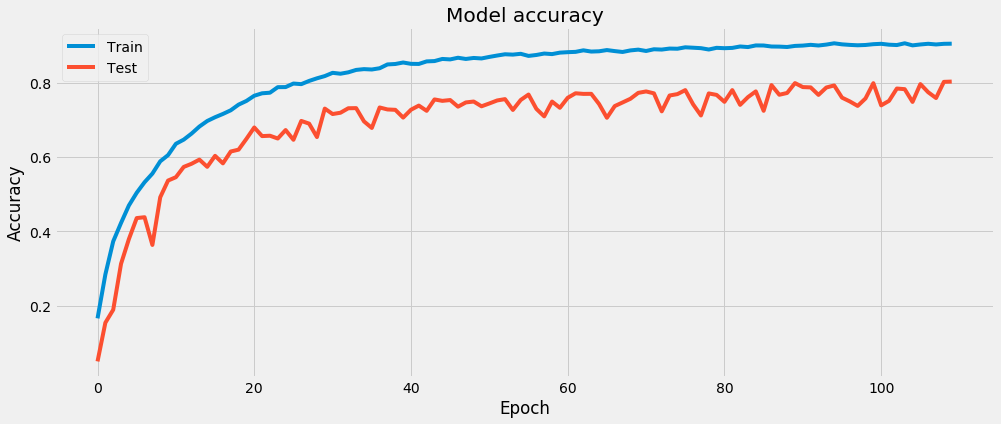

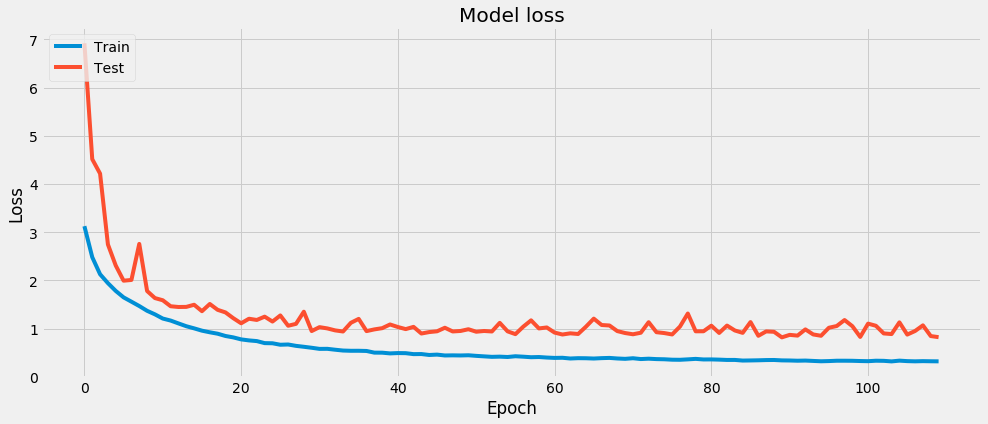

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Plot training & validation accuracy values
plt.figure(figsize=(15,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model
model.evaluate(X_test, y_test)

# Classification Report and Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
target_name = np.array(df['category'])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_name))

                  precision    recall  f1-score   support

             dog       0.82      0.79      0.81       227
         rooster       0.75      0.52      0.61       225
             pig       0.91      0.80      0.85       257
             cow       0.82      0.78      0.80       240
            frog       0.94      0.95      0.94       238
             cat       0.81      0.71      0.75       250
             hen       0.80      0.81      0.81       194
         insects       0.92      0.90      0.91       236
           sheep       0.92      0.91      0.92       231
            crow       0.94      0.89      0.91       243
            rain       0.96      1.00      0.98       217
       sea_waves       0.98      0.92      0.95       260
  crackling_fire       0.93      0.90      0.91       247
        crickets       0.98      0.97      0.98       232
  chirping_birds       0.94      0.96      0.95       251
     water_drops       0.89      0.60      0.72       232
            w

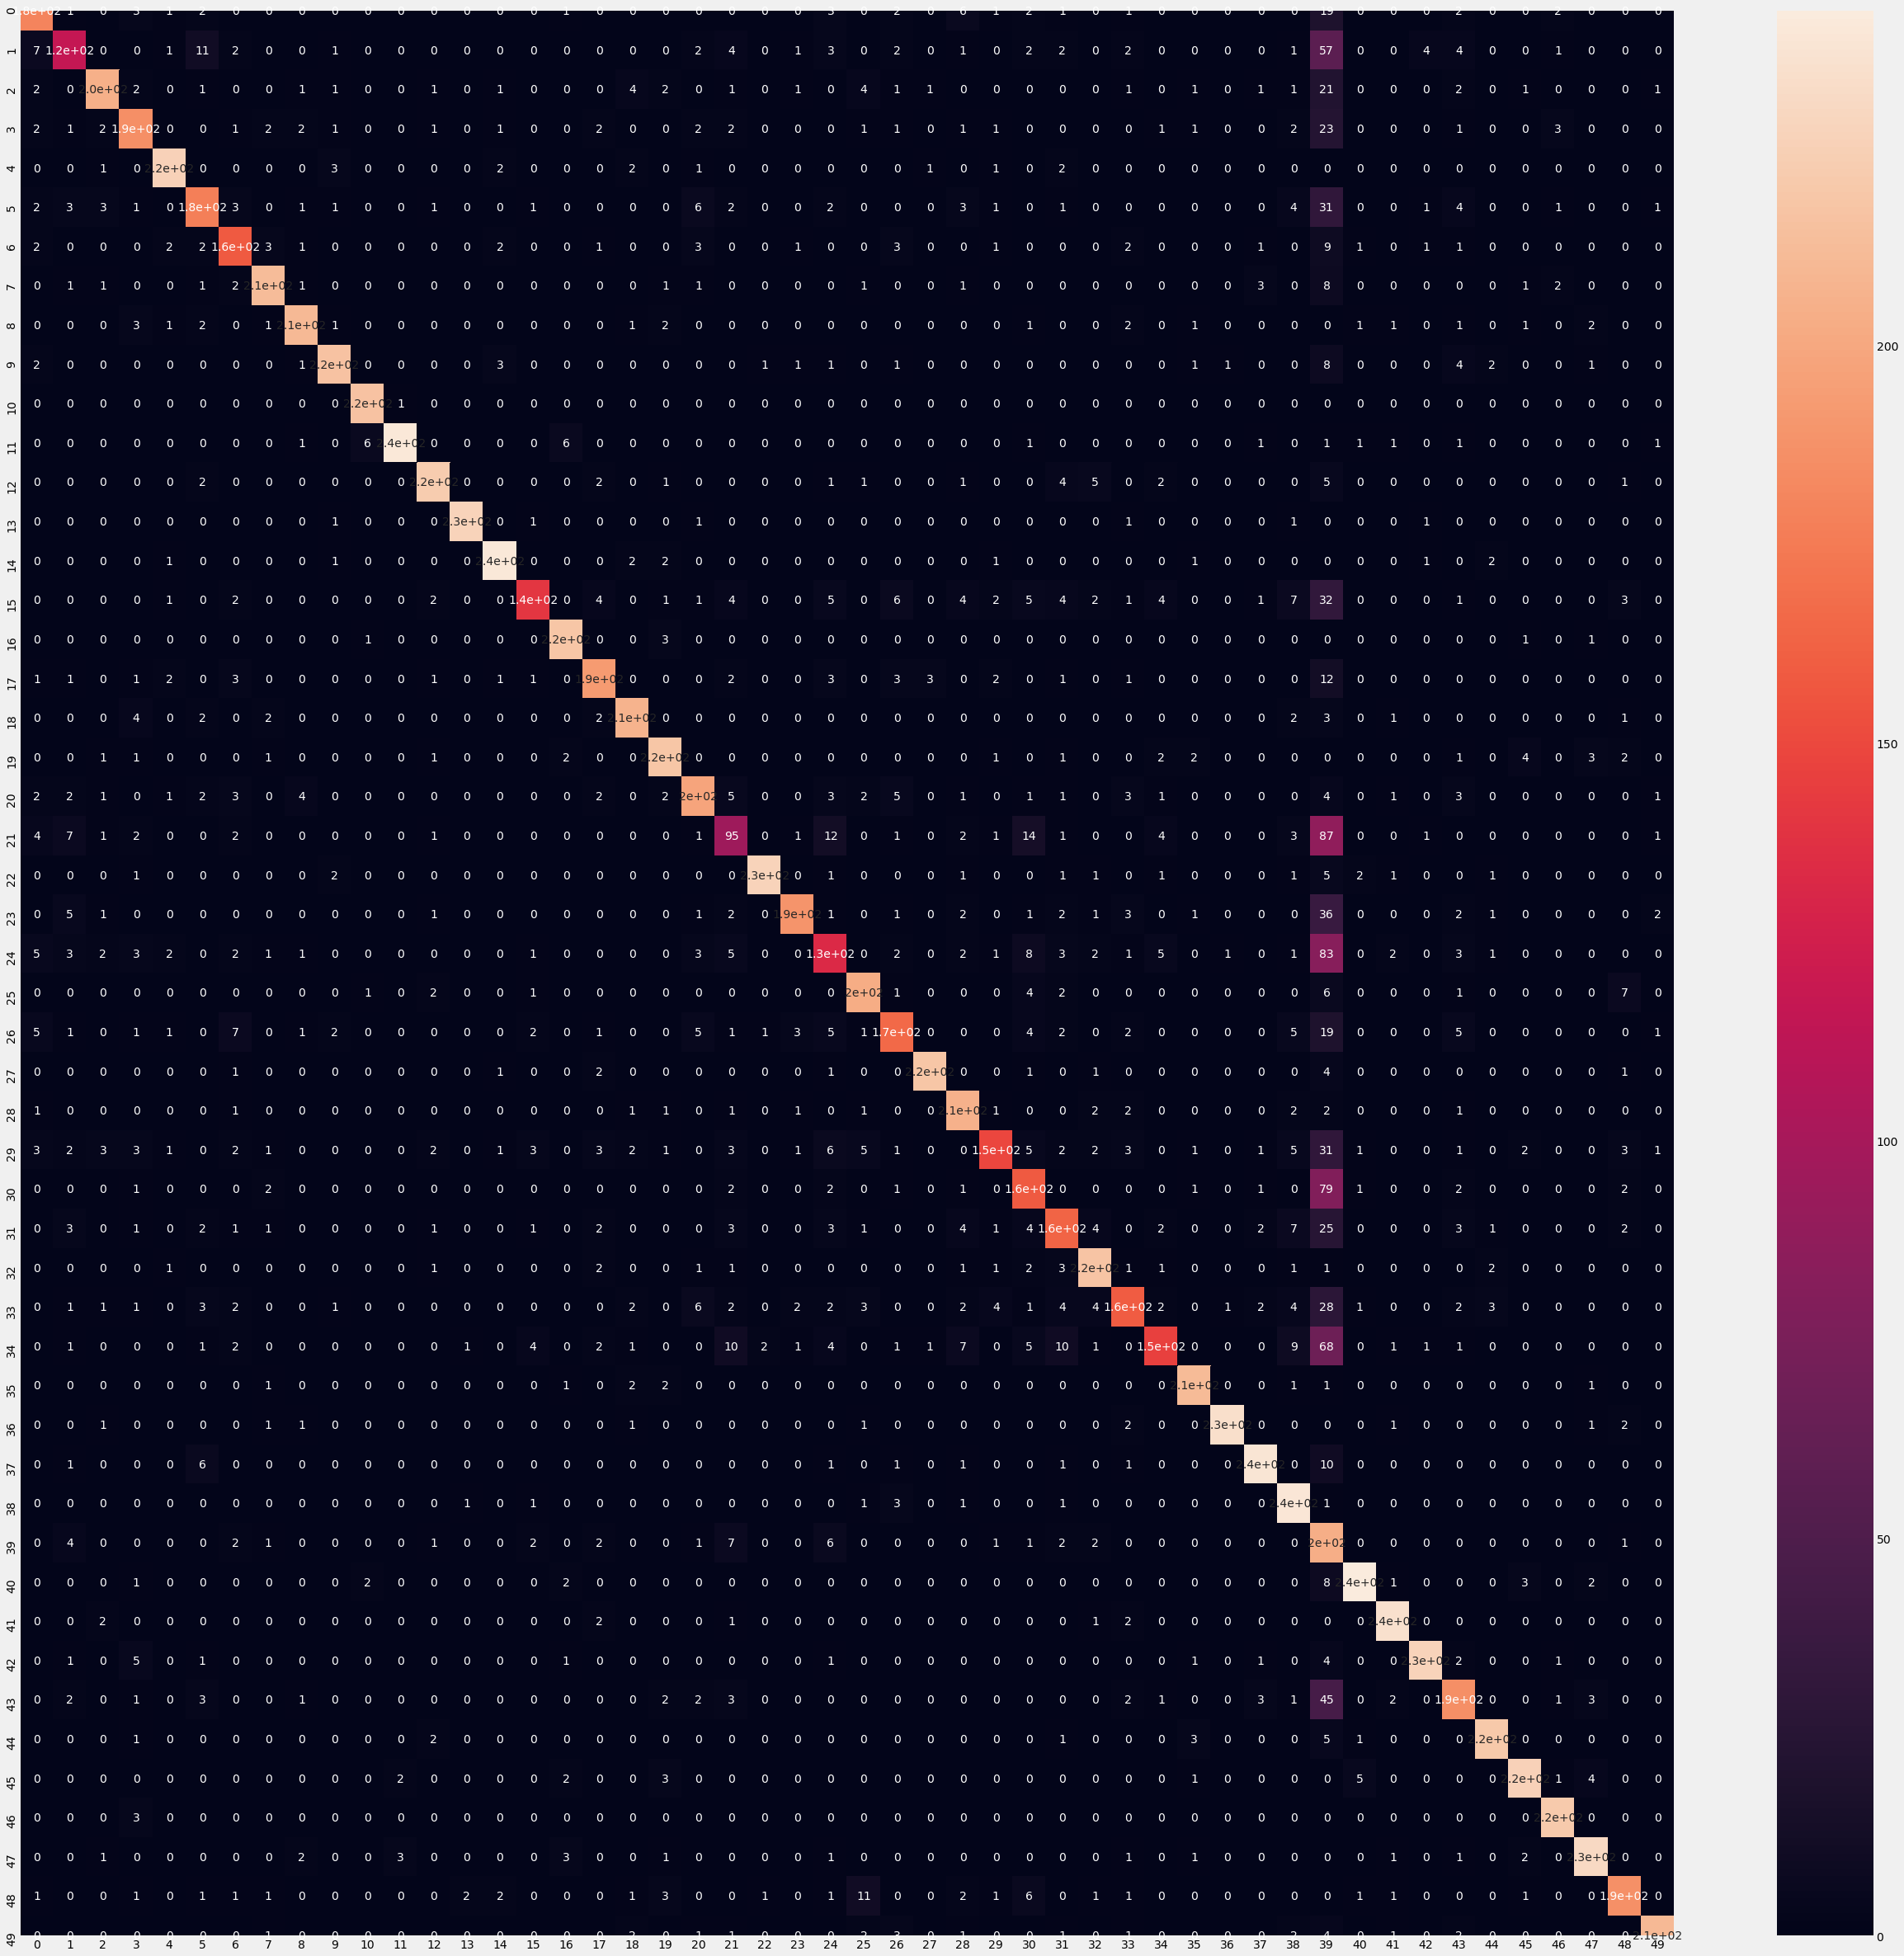

In [ ]:
import seaborn as sns
cn_matrix = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.figure(figsize = (40,40))
sns.heatmap(cn_matrix, annot=True)